In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import rgb2hex
import torch

In [2]:
file_path = 'Project/measures_v2.csv'

df = pd.read_csv(file_path)
df

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,profile_id
0,-0.450682,18.805172,19.086670,-0.350055,18.293219,0.002866,0.004419,0.000328,24.554214,18.316547,19.850691,1.871008e-01,17
1,-0.325737,18.818571,19.092390,-0.305803,18.294807,0.000257,0.000606,-0.000785,24.538078,18.314955,19.850672,2.454175e-01,17
2,-0.440864,18.828770,19.089380,-0.372503,18.294094,0.002355,0.001290,0.000386,24.544693,18.326307,19.850657,1.766153e-01,17
3,-0.327026,18.835567,19.083031,-0.316199,18.292542,0.006105,0.000026,0.002046,24.554018,18.330833,19.850647,2.383027e-01,17
4,-0.471150,18.857033,19.082525,-0.332272,18.291428,0.003133,-0.064317,0.037184,24.565397,18.326662,19.850639,2.081967e-01,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1330811,-2.152128,30.721298,45.274497,0.791801,41.934347,0.000380,-2.000169,1.097528,62.147780,38.653720,23.989078,-8.116730e-60,71
1330812,-2.258684,30.721306,45.239017,0.778900,41.868923,0.002985,-2.000499,1.097569,62.142646,38.656328,23.970700,-5.815891e-60,71
1330813,-2.130312,30.721312,45.211576,0.804914,41.804819,0.002301,-1.999268,1.098765,62.138387,38.650923,23.977234,-4.167268e-60,71
1330814,-2.268498,30.721316,45.193508,0.763091,41.762220,0.005662,-2.000999,1.095696,62.133422,38.655686,24.001421,-2.985978e-60,71


In [3]:
#Sorting the value of the measurement sessions

#The 'mergesort' algorithm is a stable sort, meaning that it maintains the
#relative order of rows with equal 'profile_id' values. However, this code
#creates a new DataFrame sorted_df with the sorted data.
print(df.head(10))
df.sort_values(by='profile_id', kind='mergesort', inplace=True)
unique_values = df['profile_id'].unique()
print(unique_values)

        u_q    coolant  stator_winding       u_d  stator_tooth  motor_speed  \
0 -0.450682  18.805172       19.086670 -0.350055     18.293219     0.002866   
1 -0.325737  18.818571       19.092390 -0.305803     18.294807     0.000257   
2 -0.440864  18.828770       19.089380 -0.372503     18.294094     0.002355   
3 -0.327026  18.835567       19.083031 -0.316199     18.292542     0.006105   
4 -0.471150  18.857033       19.082525 -0.332272     18.291428     0.003133   
5 -0.538973  18.901548       19.077108  0.009147     18.290628     0.009636   
6 -0.653148  18.941711       19.074583  0.238890     18.292524     0.001337   
7 -0.758392  18.960861       19.082499  0.395099     18.294041     0.001422   
8 -0.727128  18.973545       19.085533  0.546623     18.291964     0.000577   
9 -0.874307  18.987812       19.076025  0.578944     18.287233    -0.001248   

        i_d       i_q         pm  stator_yoke    ambient    torque  profile_id  
0  0.004419  0.000328  24.554214    18.316547  19

In [4]:
# Remove the specified columns
df.drop(['stator_tooth', 'coolant', 'stator_winding', 'torque'], axis=1, inplace=True)

In [5]:
# Let's rename the stator_yoke variable to stator_temp
df.rename(columns={'stator_yoke': 'stator_temp'}, inplace=True)

# Check the first few rows to confirm the columns are removed
print(df.head())

            u_q       u_d  motor_speed       i_d       i_q         pm  \
90975  4.921712  0.051183    99.964539 -0.000385  0.000221  23.153740   
90976  4.948537  0.074807   100.017822 -0.002003  0.000886  23.153469   
90977  4.941477  0.063648    99.999977  0.000156 -0.000046  23.147993   
90978  4.921178  0.076738    99.980309  0.001466 -0.001133  23.135658   
90979  4.924347  0.084553   100.023392  0.000682  0.003452  23.137959   

       stator_temp    ambient  profile_id  
90975    18.395088  19.995035           2  
90976    18.376493  19.954098           2  
90977    18.371748  19.924765           2  
90978    18.375002  19.903748           2  
90979    18.378679  19.888687           2  


In [6]:
#function to trim sessions to an appropriate size
def preprocess(sessions_id, seq_len, target="pm"):
    sessions = []
    for id in sessions_id:
        s = df[df["profile_id"] == id]
        r = len(s) % seq_len
        l = len(s) - r
        
        session = s.iloc[:l]
        
        y = session[target]
        X = session.drop([target, "profile_id"], axis=1)
        
        X = torch.from_numpy(X.values).float() 
        y = torch.from_numpy(y.values).float()

        sessions.append((X, y))
        
    return sessions

In [8]:
import torch.nn as nn

#Bidirectional LSTM class
class NET(nn.Module):
    def __init__(self, in_size, h_size, n_layers, out_size):
        super(NET, self).__init__()
        self.h_size = h_size
        self.n_layers = n_layers
        self.out_size = out_size
        self.lstm = nn.LSTM(in_size, h_size, n_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(h_size * 2, out_size)
             
    def forward(self, x):
        #init. states 
        h0 = torch.zeros(self.n_layers * 2, x.size(0), self.h_size)
        c0 = torch.zeros(self.n_layers * 2, x.size(0), self.h_size)
        
        out, _ = self.lstm(x, (h0, c0)) 
        out = self.fc(out)
        return out 

In [9]:
#defining the sequence length and the sessions ids which are used for training
seq_len = 100
ids = [4, 6, 10, 11, 20, 27, 29, 30, 31,32, 36] + [i+41 for i in range(35)]

#trim sessions
sessions = preprocess(ids, seq_len)

#create an lstm instance
model = NET(7, 20, 2, 1)
print(model)

#define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

NET(
  (lstm): LSTM(7, 20, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=40, out_features=1, bias=True)
)


Epoch [1/30], Loss: 2640.1814
Epoch [2/30], Loss: 1312.2587
Epoch [3/30], Loss: 694.1669
Epoch [4/30], Loss: 432.4117
Epoch [5/30], Loss: 330.1363
Epoch [6/30], Loss: 291.4471
Epoch [7/30], Loss: 276.6667
Epoch [8/30], Loss: 270.9178
Epoch [9/30], Loss: 268.6577
Epoch [10/30], Loss: 267.7379
Epoch [11/30], Loss: 267.3134
Epoch [12/30], Loss: 267.0637
Epoch [13/30], Loss: 266.8751
Epoch [14/30], Loss: 266.7099
Epoch [15/30], Loss: 266.5570
Epoch [16/30], Loss: 266.4128
Epoch [17/30], Loss: 266.2709
Epoch [18/30], Loss: 266.1431
Epoch [19/30], Loss: 266.0188
Epoch [20/30], Loss: 265.9057
Epoch [21/30], Loss: 265.7863
Epoch [22/30], Loss: 265.6779
Epoch [23/30], Loss: 265.5756
Epoch [24/30], Loss: 265.4750
Epoch [25/30], Loss: 265.3766
Epoch [26/30], Loss: 281.1162
Epoch [27/30], Loss: 266.0753
Epoch [28/30], Loss: 265.7166
Epoch [29/30], Loss: 279.8219
Epoch [30/30], Loss: 271.8744


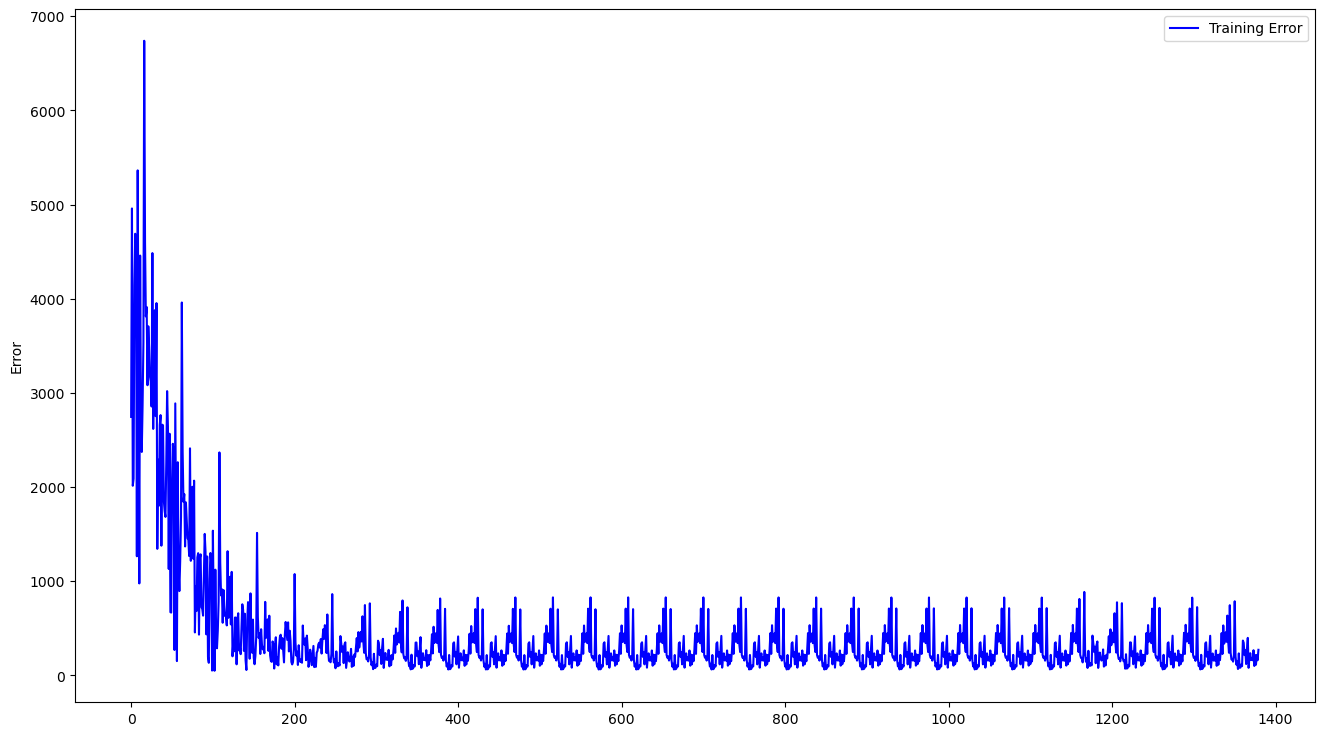

In [10]:
n_epochs = 30
seq_len = 100
number_of_features = len(df.columns) -2


#train model
train_losses = []

model.train()
for epoch in range(n_epochs):
    for X, y in sessions:
        optimizer.zero_grad()
        out = model.forward(X.view(-1, seq_len, number_of_features))
        loss = criterion(out, y.view(-1, seq_len, 1))
        
        loss.backward()
        optimizer.step()
        train_losses.append(loss.detach().numpy())
    
    print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}')

    
#print training error
plt.rcParams["figure.figsize"] = [16, 9]
plt.plot(train_losses, 'b', label='Training Error')
plt.legend(loc='upper right')
plt.ylabel('Error')
plt.show()

**RNN with scaled Features**

In [14]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
excluding_features = ['pm', 'profile_id']
df_excluding_features = df.drop(excluding_features, axis=1)
scaler.fit(df_excluding_features)

df_scaled = scaler.transform(df_excluding_features)

pm_column = df['pm'].values
profile_id_column = df['profile_id'].values
scaled_df = np.column_stack((df_scaled, pm_column, profile_id_column))

scaled_df = pd.DataFrame(scaled_df, columns=df.columns)



In [15]:
#defining the sequence length and the sessions ids which are used for training
seq_len = 100
ids = [4, 6, 10, 11, 20, 27, 29, 30, 31,32, 36] + [i+41 for i in range(35)]

#trim sessions
sessions = preprocess(ids, seq_len)

#create an lstm instance
model = NET(7, 20, 2, 1)
print(model)

#define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

NET(
  (lstm): LSTM(7, 20, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=40, out_features=1, bias=True)
)


Epoch [1/30], Loss: 2651.7617
Epoch [2/30], Loss: 1280.3975
Epoch [3/30], Loss: 663.6159
Epoch [4/30], Loss: 415.1767
Epoch [5/30], Loss: 321.8996
Epoch [6/30], Loss: 287.6982
Epoch [7/30], Loss: 274.9581
Epoch [8/30], Loss: 270.1233
Epoch [9/30], Loss: 268.2641
Epoch [10/30], Loss: 267.5103
Epoch [11/30], Loss: 267.1496
Epoch [12/30], Loss: 266.9228
Epoch [13/30], Loss: 266.7423
Epoch [14/30], Loss: 266.5755
Epoch [15/30], Loss: 266.4294
Epoch [16/30], Loss: 266.2776
Epoch [17/30], Loss: 266.1500
Epoch [18/30], Loss: 266.0246
Epoch [19/30], Loss: 265.8998
Epoch [20/30], Loss: 266.1333
Epoch [21/30], Loss: 265.6978
Epoch [22/30], Loss: 265.6000
Epoch [23/30], Loss: 265.1518
Epoch [24/30], Loss: 265.4657
Epoch [25/30], Loss: 284.9227
Epoch [26/30], Loss: 282.1974
Epoch [27/30], Loss: 263.8014
Epoch [28/30], Loss: 285.7173
Epoch [29/30], Loss: 283.8875
Epoch [30/30], Loss: 280.6641


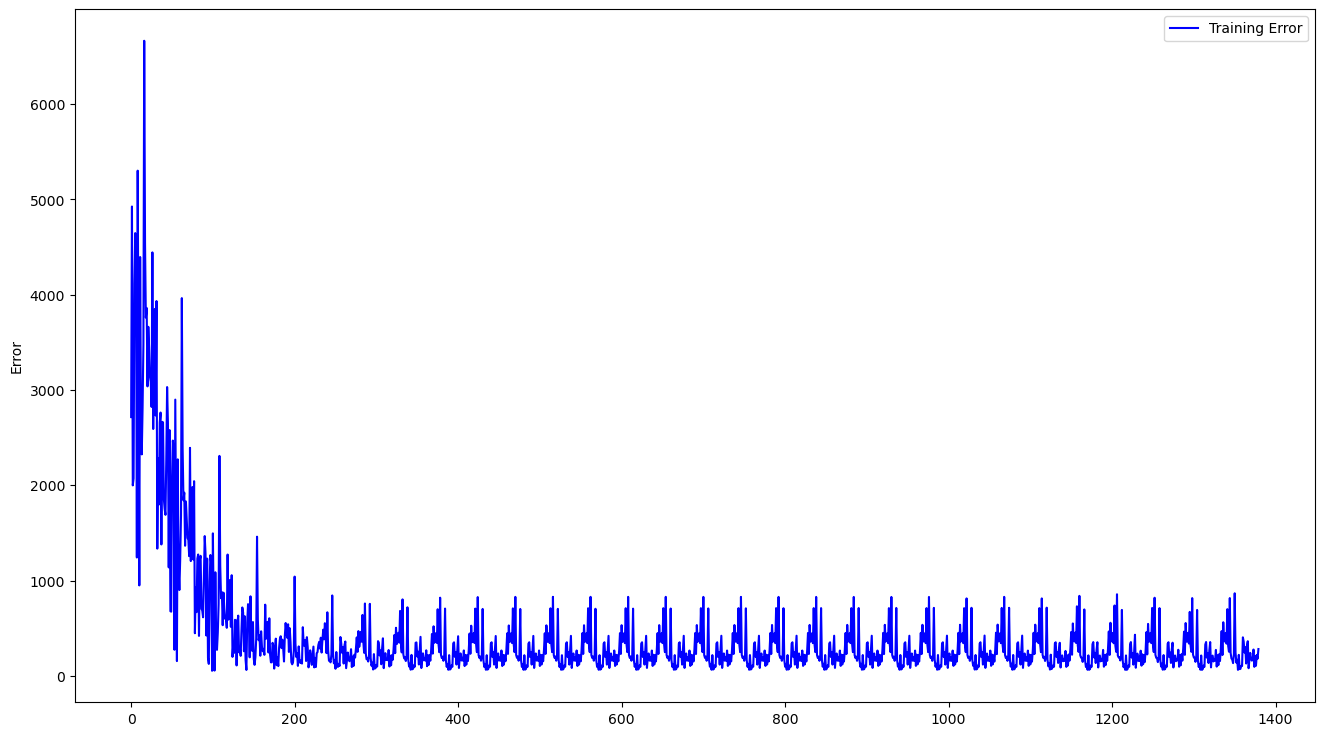

In [16]:
n_epochs = 30
seq_len = 100
number_of_features = len(df.columns) -2


#train model
train_losses = []

model.train()
for epoch in range(n_epochs):
    for X, y in sessions:
        optimizer.zero_grad()
        out = model.forward(X.view(-1, seq_len, number_of_features))
        loss = criterion(out, y.view(-1, seq_len, 1))
        
        loss.backward()
        optimizer.step()
        train_losses.append(loss.detach().numpy())
    
    print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}')

    
#print training error
plt.rcParams["figure.figsize"] = [16, 9]
plt.plot(train_losses, 'b', label='Training Error')
plt.legend(loc='upper right')
plt.ylabel('Error')
plt.show()